In [5]:
import random 
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay, auc, plot_roc_curve, f1_score, r2_score

from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced

import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter

mpl.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-bright')

import h5py

Declare constants

In [6]:
TRAIN_TEST_CUTOFF = '2020-01-31'
TRAIN_VALID_RATIO = 0.75

Define metric functions

In [7]:
def _recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
 
def _precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
 
def _f1(y_true, y_pred):
    precision = _precision(y_true, y_pred)
    recall = _recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
 
def f1macro(y_true, y_pred):
    f_pos = _f1(y_true, y_pred)
    # negative version of the data and prediction
    f_neg = _f1(1-y_true, 1-K.clip(y_pred,0,1))
    return (f_pos + f_neg)/2

In [8]:
def cnnpred_2d(seq_len=60, n_features=74, n_filters=(8,8,8), droprate=0.1):
    "2D-CNNpred model according to the paper"
    
    model = Sequential([
        Input(shape=(seq_len, n_features, 1)),
        Conv2D(n_filters[0], kernel_size=(1, n_features), activation="relu"),
        Conv2D(n_filters[1], kernel_size=(3,1), activation="relu"),
        MaxPool2D(pool_size=(2,1)),
        Conv2D(n_filters[2], kernel_size=(3,1), activation="relu"),
        MaxPool2D(pool_size=(2,1)),
        Flatten(),
        Dropout(droprate),
        Dense(1, activation="sigmoid")
    ])

    return model

cnnpred_2d().summary()

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 1, 8)          600       
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 1, 8)          200       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 1, 8)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 1, 8)          200       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 1, 8)         0         
 2D)                                                             
                                        

2022-08-12 18:54:18.322436: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-12 18:54:18.322563: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
def datagen(df, seq_len, batch_size, target_col, kind):
    """A generator to produce samples for Keras model"""

    batch = []

    while True:

        # Set up splitting parameters
        input_cols = [c for c in df.columns if c != target_col]
        index = df.index[df.index < TRAIN_TEST_CUTOFF]
        split = int(len(index) * TRAIN_VALID_RATIO)

        # Range for the training set
        if kind == 'train':
            index = index[:split]

        # Range for the validation set
        elif kind == 'valid':
            index = index[split:]   

        while True:
            "Pick one position, then clip a sequence length"

            # Pick one time step
            t = random.choice(index)

            # Find its position in the DataFrame      
            n = (df.index == t).argmax()

            # Start over if there isn't enough data for one sequence length  
            if (n - seq_len + 1) < 0:
                continue
            
            # Create the DataFrame of one sequence length
            frame = df.iloc[n - seq_len+1 : n+1]

            # Append X and y values as a sample in the CNN dataset
            batch.append([frame[input_cols].values, df.loc[t, target_col]])

            break

        # If we get enough for a batch, yield the instance
        if len(batch) == batch_size:

            # Unpack the `batch` list into features and target
            X, y = zip(*batch)

            # Expand dimensions of X
            X, y = np.expand_dims(np.array(X), 3), np.array(y)

            # Yield the sample
            yield X, y

            # Clear the batch list for next iteration
            batch = []

In [10]:
def testgen(df, seq_len, target_col):
    "Return array of all test samples"

    batch = []

    input_cols = [c for c in df.columns if c != target_col]

    # find the start of test sample
    t = df.index[df.index > TRAIN_TEST_CUTOFF][0]
    n = (df.index == t).argmax()

    for i in range(n+1, len(df)+1):

        frame = df.iloc[i-seq_len:i]
        batch.append([frame[input_cols].values, frame[target_col][-1]])

    X, y = zip(*batch)

    return np.expand_dims(np.array(X),3), np.array(y)

In [11]:
data = pd.read_csv('../csv/initial_variables.csv', index_col='date', parse_dates=True, infer_datetime_format=True)

In [12]:
cols = data.columns

# If the current price is higher than yesterday's price then target = 1, else 0
data['target'] = (data['close'].pct_change().shift(-1) > 0).astype(int)

data.dropna(inplace=True)

# Fit the scaler using the training dataset
index = data.index[data.index > TRAIN_TEST_CUTOFF]
index = index[:int(len(index) * TRAIN_VALID_RATIO)]
scaler = MinMaxScaler().fit(data.loc[index, cols])

# Save scale transformed dataframe
data[cols] = scaler.transform(data[cols])
data

,open,high,low,close,volume,trend,rsi,rsi_fast_k,rsi_fast_d,williams_r,...,stk_wmt,stk_xom,usd_aud,usd_cad,usd_cny,usd_eur,usd_hkd,usd_jpy,day_of_week,target
date,,,,,,,,,,,,,,,,,,,,,
2012-08-01,-0.376407,-0.374811,-0.327073,-0.348369,0.319761,-0.574346,0.589285,0.394278,0.732668,0.737008,...,-0.828320,0.812334,-0.614870,-0.815380,0.021953,0.024215,0.080446,-1.970473,0.50,0
2012-08-02,-0.378137,-0.378863,-0.334545,-0.352539,0.288836,-0.573524,0.534255,0.000000,0.405188,0.571438,...,-0.821414,0.793945,-0.612061,-0.809202,0.030443,0.051555,0.104315,-1.949612,0.75,1
2012-08-03,-0.382135,-0.371074,-0.330230,-0.342036,0.233466,-0.572855,0.643092,0.937216,0.443831,0.951483,...,-0.813385,0.823759,-0.609970,-0.799731,0.028987,0.083581,0.090072,-1.962449,1.00,1
2012-08-06,-0.371566,-0.368835,-0.320004,-0.340727,0.154756,-0.572257,0.655480,1.000000,0.645739,0.923521,...,-0.817721,0.821973,-0.628568,-0.826070,0.033718,-0.044524,0.090843,-1.931157,0.00,1
2012-08-07,-0.370154,-0.365761,-0.318638,-0.337850,0.224873,-0.571278,0.682726,1.000000,0.979072,0.925917,...,-0.822379,0.830364,-0.629306,-0.825949,0.036750,-0.024996,0.104315,-1.964054,0.25,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-26,0.686622,0.676391,0.686857,0.680367,0.149923,0.625614,0.476807,0.000000,0.329419,0.685404,...,0.442235,1.692497,0.379347,0.330339,0.492177,1.309952,1.915902,2.708257,0.25,1
2022-07-27,0.685882,0.711731,0.703116,0.721812,0.212572,0.629898,0.582036,1.000000,0.421536,0.950153,...,0.534936,1.745130,0.380967,0.339688,0.507702,1.381893,1.918398,2.751505,0.50,1
2022-07-28,0.716734,0.727854,0.719716,0.741540,0.249940,0.636176,0.626632,1.000000,0.666667,0.982153,...,0.598480,1.774160,0.360919,0.316682,0.501759,1.321669,1.915324,2.682580,0.75,1


In [13]:
seq_len = 60
batch_size = 64
n_epochs = 20
n_features = 74
 
model = cnnpred_2d(seq_len, n_features)
model.compile(optimizer='adam', loss='mae', metrics=['acc', f1macro])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 60, 1, 8)          600       
                                                                 
 conv2d_4 (Conv2D)           (None, 58, 1, 8)          200       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 1, 8)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 27, 1, 8)          200       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 1, 8)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 104)              

In [14]:
checkpoint_path = './models/cp2d-{epoch}-{val_f1macro:.2f}.h5'
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode='max', verbose=0,
                    save_best_only=True, save_weights_only=False, save_freq='epoch')
]

In [15]:
training_gen = datagen(data, seq_len, batch_size, 'target', 'train')
validation_gen = datagen(data, seq_len, batch_size, 'target', 'valid')

model.fit(
    training_gen,
    validation_data=validation_gen,
    epochs=n_epochs, 
    steps_per_epoch=400, 
    validation_steps=10, 
    verbose=1,
    callbacks=callbacks
)

Epoch 1/20


2022-08-12 18:54:18.803081: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-12 18:54:19.244220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


399/400 [============================>.] - ETA: 0s - loss: 0.4564 - acc: 0.5458 - f1macro: 0.3519

2022-08-12 18:54:34.719133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


400/400 [==============================] - 16s 39ms/step - loss: 0.4566 - acc: 0.5456 - f1macro: 0.3519 - val_loss: 0.4579 - val_acc: 0.5422 - val_f1macro: 0.3497
Epoch 2/20
400/400 [==============================] - 15s 38ms/step - loss: 0.4545 - acc: 0.5455 - f1macro: 0.3520 - val_loss: 0.4500 - val_acc: 0.5500 - val_f1macro: 0.3544
Epoch 3/20
400/400 [==============================] - 17s 43ms/step - loss: 0.4539 - acc: 0.5461 - f1macro: 0.3522 - val_loss: 0.4547 - val_acc: 0.5453 - val_f1macro: 0.3524
Epoch 4/20
400/400 [==============================] - 16s 39ms/step - loss: 0.4505 - acc: 0.5495 - f1macro: 0.3535 - val_loss: 0.3875 - val_acc: 0.6125 - val_f1macro: 0.3792
Epoch 5/20
400/400 [==============================] - 16s 39ms/step - loss: 0.4495 - acc: 0.5505 - f1macro: 0.3541 - val_loss: 0.4531 - val_acc: 0.5469 - val_f1macro: 0.3529
Epoch 6/20
400/400 [==============================] - 16s 39ms/step - loss: 0.4566 - acc: 0.5434 - f1macro: 0.3511 - val_loss: 0.4188 - val_a

In [16]:
# Prepare test data
test_data, test_target = testgen(data, seq_len, "target")
 
# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("MAE:", mean_absolute_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))

20/20 [==============================] - 0s 5ms/step
accuracy: 0.5421303656597775
MAE: 0.4578696343402226
F1: 0.7030927835051547


2022-08-12 18:59:48.964767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


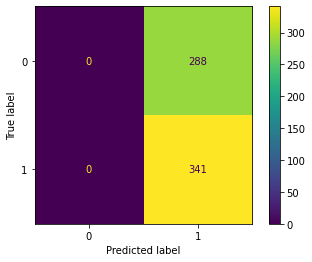

In [17]:
cm = confusion_matrix(test_target, test_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm)
disp.plot()
plt.show()

In [18]:
r2_score(test_target, test_pred)

-0.8445747800586509